In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


# Péndulo Simple

In [25]:

# Parámetros físicos del péndulo
g = 9.81  # Gravedad (m/s²)
L = 1.0   # Longitud (m)
theta0 = np.pi/4  # Ángulo inicial (rad)
initial_velocity = 0.0  # Velocidad inicial (rad/s)

# Crear la red neuronal (PINN)
class PINN(tf.keras.Model):
    def __init__(self, layers=[1, 32, 32, 32, 1]):
        super(PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(neurons, activation="tanh") for neurons in layers[1:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)

    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Generar datos de entrenamiento
t_train = np.linspace(0, 3, 100).reshape(-1, 1)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)

# Crear modelo
model = PINN()

# Función de pérdida con condiciones iniciales (corregida)
@tf.function
def loss_fn():
    # Pérdida del residual de la ecuación
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_train_tf)
        theta_pred = model(t_train_tf)
        dtheta_dt = tape.gradient(theta_pred, t_train_tf)
        d2theta_dt2 = tape.gradient(dtheta_dt, t_train_tf)
        # residual = d2theta_dt2 + (g/L) * tf.sin(theta_pred)  # Usar sin(θ)
        residual = d2theta_dt2 + (g/L) * theta_pred  # Usar sin(θ)
    
    loss_residual = tf.reduce_mean(tf.square(residual))

    # Condiciones iniciales (CORRECCIÓN: monitorear t_initial)
    t_initial = tf.constant([[0.0]], dtype=tf.float32)
    with tf.GradientTape() as tape_initial:
        tape_initial.watch(t_initial)  # ¡Importante!
        theta_initial = model(t_initial)
    dtheta_dt_initial = tape_initial.gradient(theta_initial, t_initial)
    
    # Asegurar que las derivadas existen (CORRECCIÓN: verificar None)
    if dtheta_dt_initial is None:
        dtheta_dt_initial = tf.constant(0.0)  # Fallback seguro
    
    loss_theta0 = tf.reduce_mean(tf.square(theta_initial - theta0))
    loss_velocity0 = tf.reduce_mean(tf.square(dtheta_dt_initial - initial_velocity))

    # Pérdida total
    return loss_residual + loss_theta0 + loss_velocity0

# Optimizador
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


Epoch 900: Loss = 0.0007345984340645373


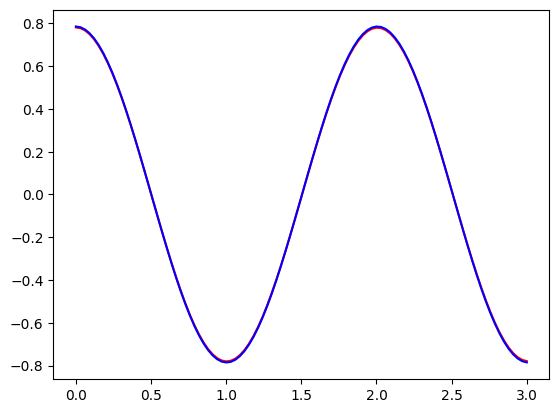

In [34]:
from IPython.display import clear_output
# Entrenamiento
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")
        plt.plot(t_train, model(t_train_tf), 'r')
        # pintamos el real
        theta_real = theta0 * np.cos(np.sqrt(g/L) * t_train)
        plt.plot(t_train, theta_real, 'b')
        plt.show()
        clear_output(wait=True)


In [4]:
# guardamos el modelo para usarlo en el futuro
model.save('pendulum_model.keras')

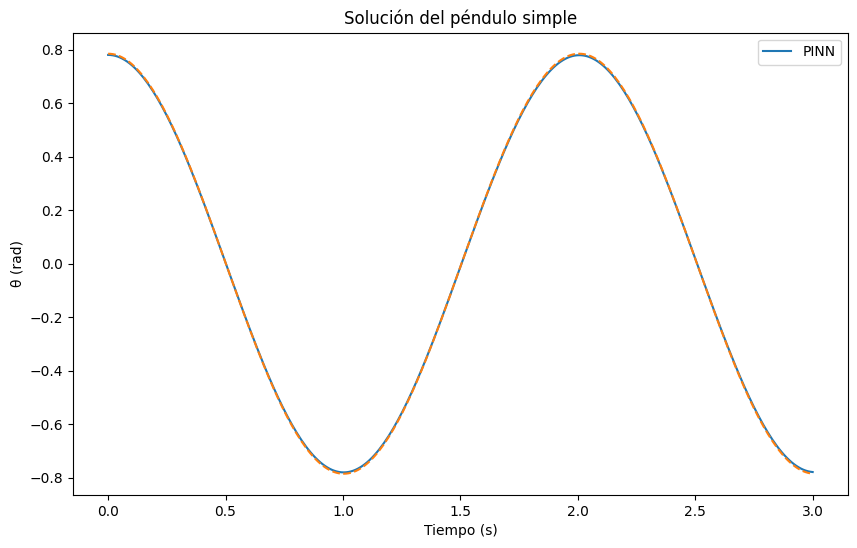

In [41]:

# Graficar solución
t_test = np.linspace(0, 3, 300)
theta_pred = model(t_test.reshape(-1, 1)).numpy()

plt.figure(figsize=(10,6))
plt.plot(t_test, theta_pred, label='PINN')
plt.title('Solución del péndulo simple')
plt.xlabel('Tiempo (s)')
plt.ylabel('θ (rad)')
plt.legend()

# Comparar con la solución analítica
theta_analytic = theta0 * np.cos(np.sqrt(g/L) * t_test)
plt.plot(t_test, theta_analytic, label='Analítica', linestyle='dashed')

plt.show()

# Péndulo Doble

In [45]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos
m1 = 1.0
m2 = 1.0
L1 = 1.0
L2 = 1.0
g = 9.81

# Red neuronal
class DoublePendulumPINN(tf.keras.Model):
    def __init__(self, layers=[1, 64, 64, 64, 2]):
        super(DoublePendulumPINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(n, activation="tanh") for n in layers[1:-1]]
        self.output_layer = tf.keras.layers.Dense(layers[-1], activation=None)
    
    def call(self, t):
        x = t
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Datos de entrenamiento
t_train = np.linspace(0, 5, 200).reshape(-1, 1)
t_train_tf = tf.convert_to_tensor(t_train, dtype=tf.float32)

# Modelo y optimizador
model = DoublePendulumPINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

# Función de pérdida
@tf.function
def loss_fn():
    # Pérdida del residual de las ecuaciones
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t_train_tf)
        predictions = model(t_train_tf)
        theta1, theta2 = predictions[:, 0:1], predictions[:, 1:2]
        
        # Primeras derivadas
        dtheta1_dt = tape.gradient(theta1, t_train_tf)
        dtheta2_dt = tape.gradient(theta2, t_train_tf)
        
        # Segundas derivadas
        d2theta1_dt2 = tape.gradient(dtheta1_dt, t_train_tf)
        d2theta2_dt2 = tape.gradient(dtheta2_dt, t_train_tf)
        
        # Ecuaciones del péndulo doble (ver referencia Lagrangiana)
        delta = theta2 - theta1
        sin_delta = tf.sin(delta)
        cos_delta = tf.cos(delta)
        denom = L1*(m1 + m2*sin_delta**2)
        
        residual1 = (
            (m1 + m2)*L1*d2theta1_dt2 + m2*L2*d2theta2_dt2*cos_delta 
            + m2*L2*(dtheta2_dt**2)*sin_delta + (m1 + m2)*g*tf.sin(theta1)
        ) / denom
        
        residual2 = (
            L2*d2theta2_dt2 + L1*d2theta1_dt2*cos_delta 
            - L1*(dtheta1_dt**2)*sin_delta + g*tf.sin(theta2)
        ) / denom
    
    loss_residual = tf.reduce_mean(tf.square(residual1) + tf.square(residual2))
    
    # Condiciones iniciales (CORRECCIÓN: usar jacobiano)
    t_initial = tf.constant([[0.0]], dtype=tf.float32)
    with tf.GradientTape() as tape_initial:
        tape_initial.watch(t_initial)
        theta_initial = model(t_initial)  # Forma (1,2)
    
    # Calcular el jacobiano (derivadas de θ1 y θ2 respecto a t)
    jacobian = tape_initial.jacobian(theta_initial, t_initial)  # Forma (1,2,1,1)
    dtheta_initial = tf.squeeze(jacobian)  # Reducir a (2,)
    
    # Pérdidas de condiciones iniciales
    loss_theta1 = tf.reduce_mean(tf.square(theta_initial[0,0] - np.pi/2))  # θ₁(0)=π/2
    loss_theta2 = tf.reduce_mean(tf.square(theta_initial[0,1] - np.pi))    # θ₂(0)=π
    loss_vel1 = tf.reduce_mean(tf.square(dtheta_initial[0] - 0.0))         # dθ₁/dt(0)=0
    loss_vel2 = tf.reduce_mean(tf.square(dtheta_initial[1] - 0.0))         # dθ₂/dt(0)=0
    
    return loss_residual + loss_theta1 + loss_theta2 + loss_vel1 + loss_vel2


Epoch 900: Loss = 0.22588153183460236


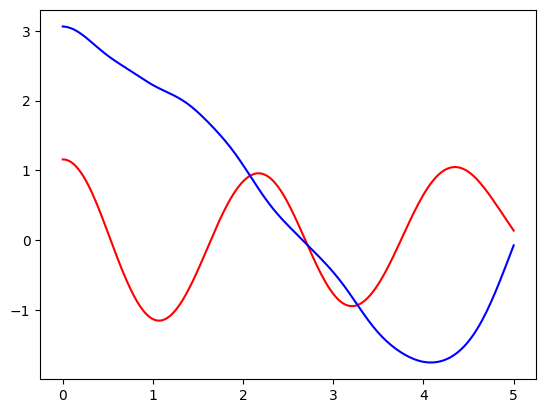

In [67]:
from IPython.display import clear_output
# Entrenamiento
for epoch in range(1000):
    with tf.GradientTape() as tape:
        loss = loss_fn()
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.numpy()}")
        plt.plot(t_train, model(t_train_tf)[:,0], 'r')
        plt.plot(t_train, model(t_train_tf)[:,1], 'b')
        plt.show()
        clear_output(wait=True)


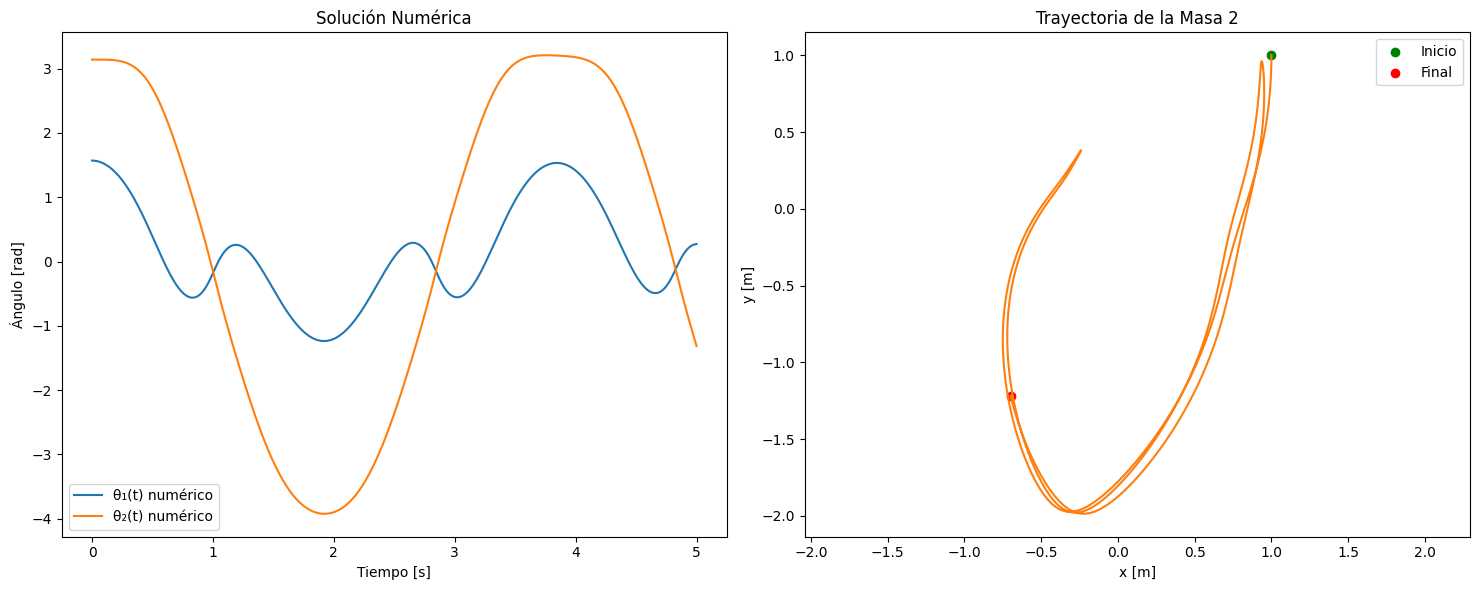

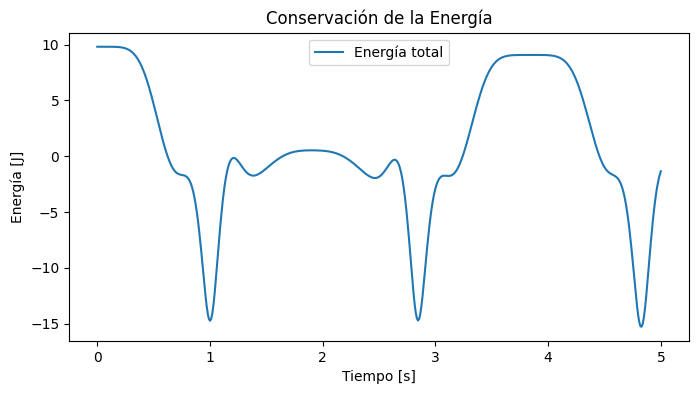

In [56]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Parámetros físicos (consistentes con la PINN)
m1 = 1.0   # Masa 1 [kg]
m2 = 1.0   # Masa 2 [kg]
L1 = 1.0   # Longitud 1 [m]
L2 = 1.0   # Longitud 2 [m]
g = 9.81   # Gravedad [m/s²]

# Condiciones iniciales
theta1_0 = np.pi/2  # Ángulo inicial péndulo 1 [rad]
theta2_0 = np.pi    # Ángulo inicial péndulo 2 [rad]
omega1_0 = 0.0      # Velocidad angular inicial 1 [rad/s]
omega2_0 = 0.0      # Velocidad angular inicial 2 [rad/s]

# Tiempo de simulación
t_span = (0, 5)     # Intervalo de tiempo [s]
t_eval = np.linspace(t_span[0], t_span[1], 500)  # Puntos de evaluación

# Definición de las ecuaciones diferenciales
def double_pendulum(t, y):
    """
    Sistema de ecuaciones del péndulo doble
    y = [θ1, θ2, ω1, ω2]
    """
    theta1, theta2, omega1, omega2 = y
    
    # Diferencias angulares
    delta = theta2 - theta1
    sin_delta = np.sin(delta)
    cos_delta = np.cos(delta)
    
    # Denominador común
    denom = (m1 + m2)*L1 - m2*L1*cos_delta**2
    
    # Aceleraciones angulares [Ecuaciones de Lagrange]
    alpha1 = (m2*L2*omega2**2*sin_delta - (m1 + m2)*g*np.sin(theta1) 
              + m2*g*np.sin(theta2)*cos_delta) / denom
    
    alpha2 = (-L1*omega1**2*sin_delta - g*np.sin(theta2) 
              + (m1 + m2)*g*np.sin(theta1)*cos_delta/L2) / denom
    
    return [omega1, omega2, alpha1, alpha2]

# Resolver el sistema de EDOs
sol = solve_ivp(double_pendulum, 
                t_span, 
                [theta1_0, theta2_0, omega1_0, omega2_0], 
                t_eval=t_eval, 
                method='DOP853', 
                rtol=1e-8)

# Extraer resultados
theta1_num = sol.y[0]
theta2_num = sol.y[1]
t_sol = sol.t

# Convertir a coordenadas cartesianas
x1 = L1 * np.sin(theta1_num)
y1 = -L1 * np.cos(theta1_num)
x2 = x1 + L2 * np.sin(theta2_num)
y2 = y1 - L2 * np.cos(theta2_num)

# Graficar resultados
plt.figure(figsize=(15, 6))

# Ángulos vs tiempo
plt.subplot(1, 2, 1)
plt.plot(t_sol, theta1_num, label='θ₁(t) numérico')
plt.plot(t_sol, theta2_num, label='θ₂(t) numérico')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.title('Solución Numérica')
plt.legend()

# Trayectoria de la masa 2
plt.subplot(1, 2, 2)
plt.plot(x2, y2, color='C1')
plt.scatter(x2[0], y2[0], color='green', label='Inicio')
plt.scatter(x2[-1], y2[-1], color='red', label='Final')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Trayectoria de la Masa 2')
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

# Energía (para verificar conservación)
def hamiltonian(y):
    theta1, theta2, omega1, omega2 = y
    # Energía cinética
    T = 0.5*(m1 + m2)*(L1*omega1)**2 + 0.5*m2*L2**2*omega2**2 + m2*L1*L2*omega1*omega2*np.cos(theta2 - theta1)
    # Energía potencial
    V = -(m1 + m2)*g*L1*np.cos(theta1) - m2*g*L2*np.cos(theta2)
    return T + V

# Calcular energía en cada paso
E = np.array([hamiltonian(sol.y[:,i]) for i in range(len(t_sol))])

# Graficar energía
plt.figure(figsize=(8,4))
plt.plot(t_sol, E, label='Energía total')
plt.xlabel('Tiempo [s]')
plt.ylabel('Energía [J]')
plt.title('Conservación de la Energía')
plt.legend()
plt.show()

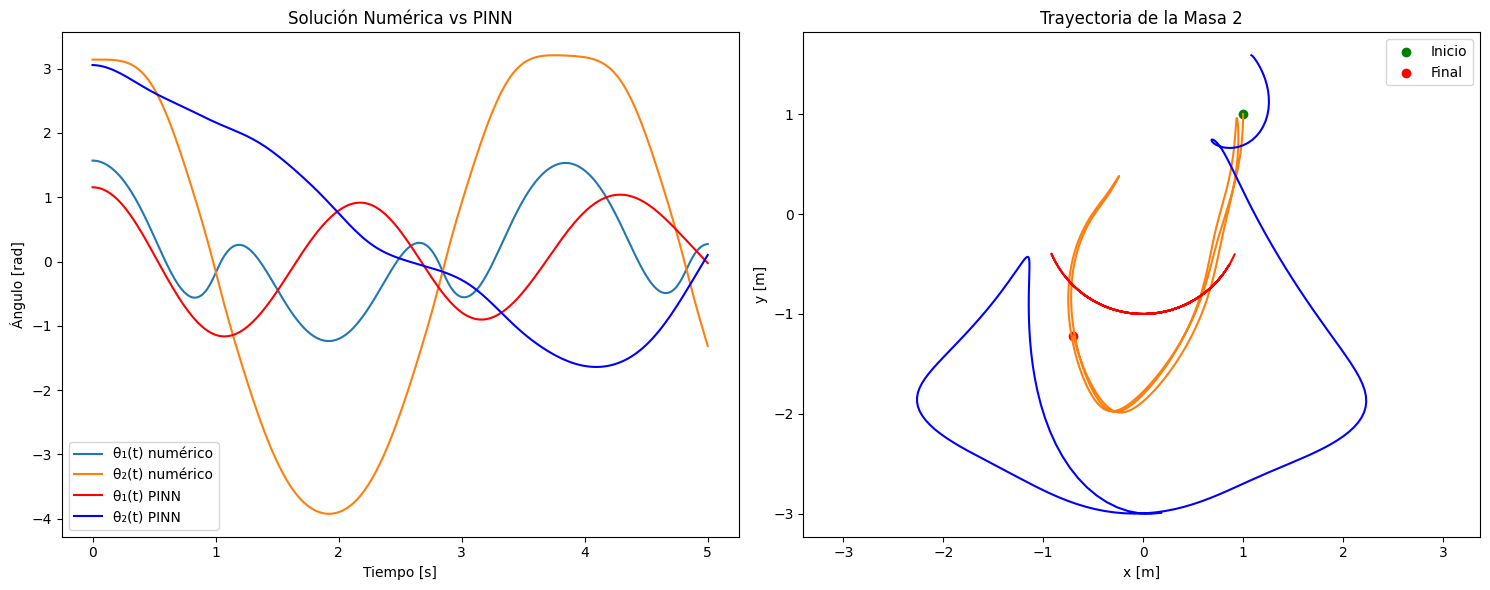

In [66]:
# representamos la solución de la red neuronal junto con la solución numérica

plt.figure(figsize=(15, 6))

# Ángulos vs tiempo
plt.subplot(1, 2, 1)
plt.plot(t_sol, theta1_num, label='θ₁(t) numérico')
plt.plot(t_sol, theta2_num, label='θ₂(t) numérico')
plt.plot(t_train, model(t_train_tf)[:,0], 'r', label='θ₁(t) PINN')
plt.plot(t_train, model(t_train_tf)[:,1], 'b', label='θ₂(t) PINN')
plt.xlabel('Tiempo [s]')
plt.ylabel('Ángulo [rad]')
plt.title('Solución Numérica vs PINN')
plt.legend()

# Trayectoria de la masa 2
plt.subplot(1, 2, 2)
plt.plot(x2, y2, color='C1')
plt.scatter(x2[0], y2[0], color='green', label='Inicio')
plt.scatter(x2[-1], y2[-1], color='red', label='Final')
plt.plot(L1*np.sin(model(t_train_tf)[:,0]), -L1*np.cos(model(t_train_tf)[:,0]), 'r')
plt.plot((L1+L2)*np.sin(model(t_train_tf)[:,1]) + L1*np.sin(model(t_train_tf)[:,0]), 
         -(L1+L2)*np.cos(model(t_train_tf)[:,1]) - L1*np.cos(model(t_train_tf)[:,0]), 'b')
plt.xlabel('x [m]')
plt.ylabel('y [m]')

plt.title('Trayectoria de la Masa 2')
plt.axis('equal')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

# Visualización
t_test = np.linspace(0, 5, 500)
predictions = model(t_test.reshape(-1, 1)).numpy()
theta1_pred = predictions[:, 0]
theta2_pred = predictions[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(t_test, theta1_pred, label='θ₁(t)')
plt.plot(t_test, theta2_pred, label='θ₂(t)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Ángulo (rad)')
plt.legend()
plt.show()